In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)
df = table[0]
df['Symbol'] = df['Symbol'].str.replace('.', '-')
tickers = df['Symbol'].tolist()

In [3]:
import yfinance as yf
from datetime import datetime, timedelta

start_date = "2020-01-30"
end_date = datetime.now().strftime('%Y-%m-%d')

stock_data = {}
for company in tickers:
    data = yf.download(company, start=start_date, end=end_date, progress=False)
    stock_data[company] = data[['Adj Close', 'Volume']]

In [4]:
metrics_df = pd.DataFrame(columns=['Log Return', 'Volatility'])
for company, data in stock_data.items():
    log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    volatility = log_returns.std() * np.sqrt(252)
    
    mean_log_return = log_returns.mean()
    metrics_df.loc[company] = [mean_log_return, volatility]

In [5]:
metrics_df.head()

,Log Return,Volatility
MMM,-0.000299,0.286114
AOS,0.000665,0.316874
ABT,0.000233,0.281844
ABBV,0.000770,0.254391
ACN,0.000546,0.308225


In [76]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler().fit(data)

scaled_data = pd.DataFrame(scale.fit_transform(metrics_df),columns = metrics_df.columns, index = metrics_df.index)
X = scaled_data
X.head()

,Log Return,Volatility
MMM,-1.208913,-0.899579
AOS,0.781277,-0.613588
ABT,-0.109932,-0.939281
ABBV,0.999681,-1.194519
ACN,0.536372,-0.694001


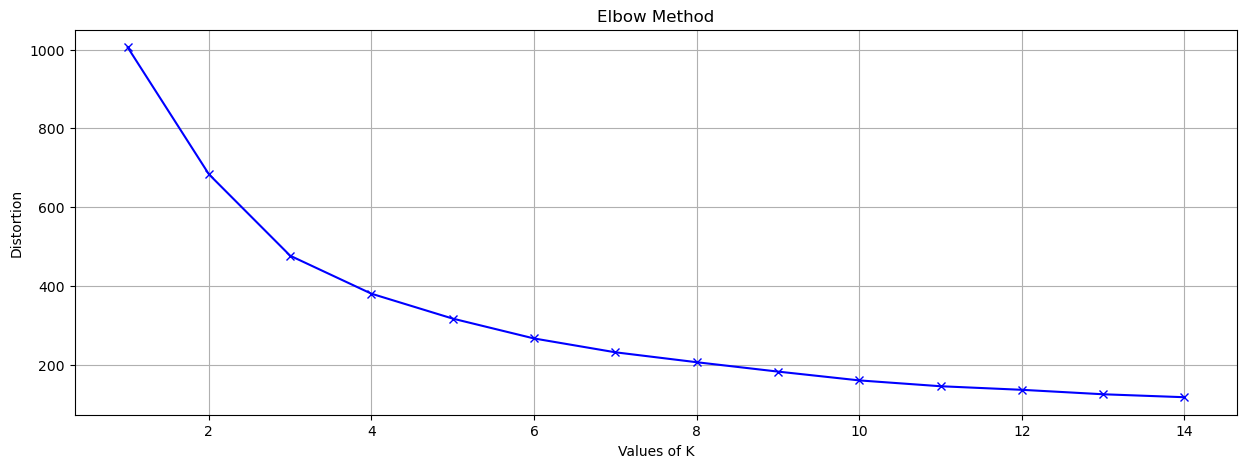

In [7]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

K = range(1,15)
distortions = []

for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

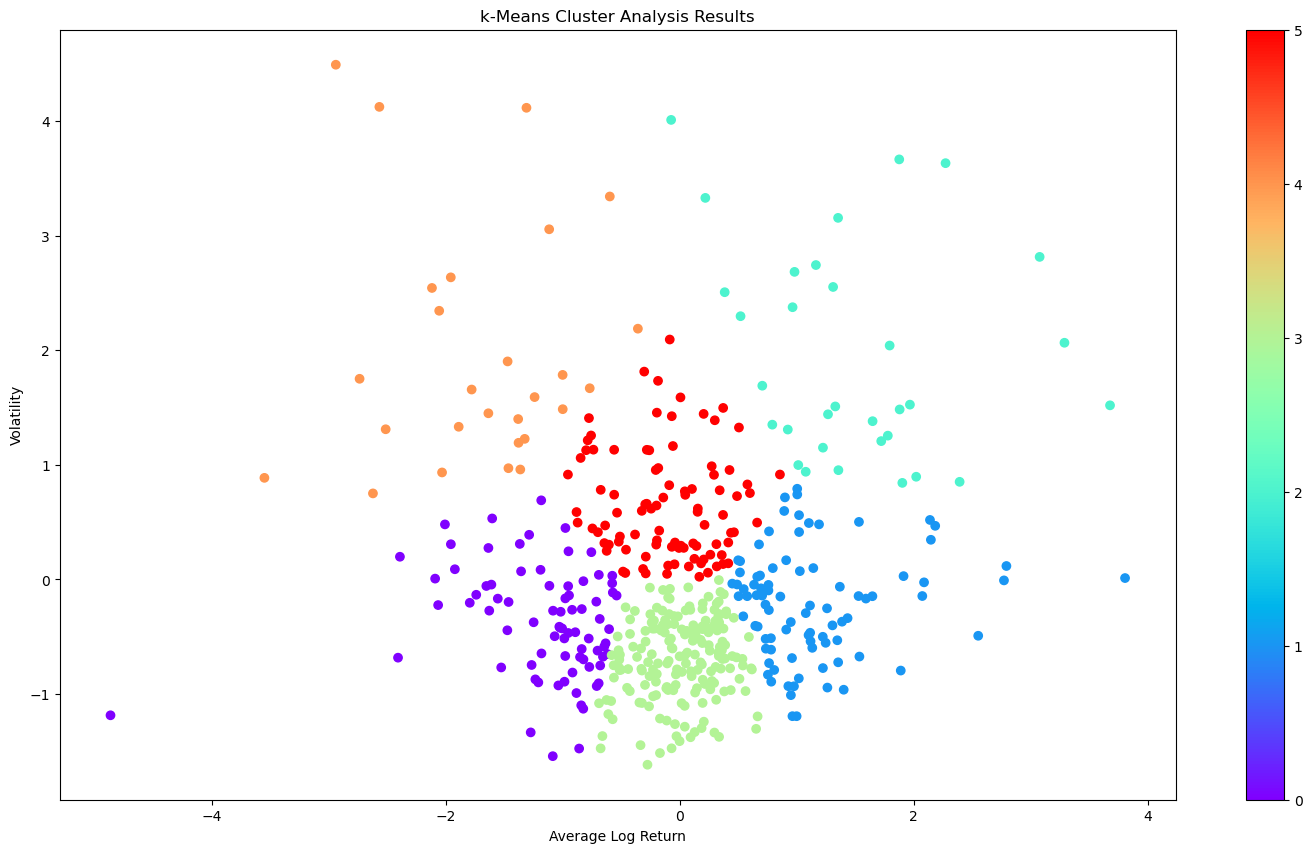

In [87]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming X is your DataFrame with Mean Return and Volatility
# and company names as the index
k_means = KMeans(n_clusters=6, random_state=671)
k_means.fit(X)
prediction = k_means.predict(X)

centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="rainbow")
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Average Log Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
# plt.plot(centroids[:, 0], centroids[:, 1], 'sk', markersize=10)

# # Find and annotate the companies closest to the centroids
# for i, centroid in enumerate(centroids):
#     # Calculate the Euclidean distance from each point to the centroid
#     distances = np.sqrt(((X - centroid) ** 2).sum(axis=1))
#     # Get the index (company name) of the minimum distance
#     closest_company_name = distances.idxmin()
#     # Annotate the plot with the closest company's name
#     plt.text(centroid[0], centroid[1], closest_company_name, fontsize=15, color='black', ha='center', va='bottom')

plt.show()


In [30]:
ticker_to_sector = df.set_index('Symbol')['GICS Sector']
comparison = scaled_data
comparison['GICS Sector'] = comparison.index.map(ticker_to_sector)
comparison['Cluster'] = prediction
comparison.head()

,Log Return,Volatility,GICS Sector,Cluster
MMM,-1.208913,-0.899579,Industrials,0
AOS,0.781277,-0.613588,Industrials,1
ABT,-0.109932,-0.939281,Health Care,3
ABBV,0.999681,-1.194519,Health Care,1
ACN,0.536372,-0.694001,Information Technology,3


In [ ]:
average_stats_per_cluster = X.assign(Cluster=prediction).groupby('Cluster').mean()
bottom_right_cluster = average_stats_per_cluster['Mean Return'].idxmax()

# Filter the companies in the bottom right cluster
companies_in_bottom_right = X[prediction == bottom_right_cluster]

# Find the company with the highest mean return and lowest volatility within the bottom right cluster
bottom_right_company = companies_in_bottom_right.loc[(companies_in_bottom_right['Mean Return'].idxmax())]

# Print the ticker of the company at the bottom right
print("Company at the bottom right:", bottom_right_company.name)

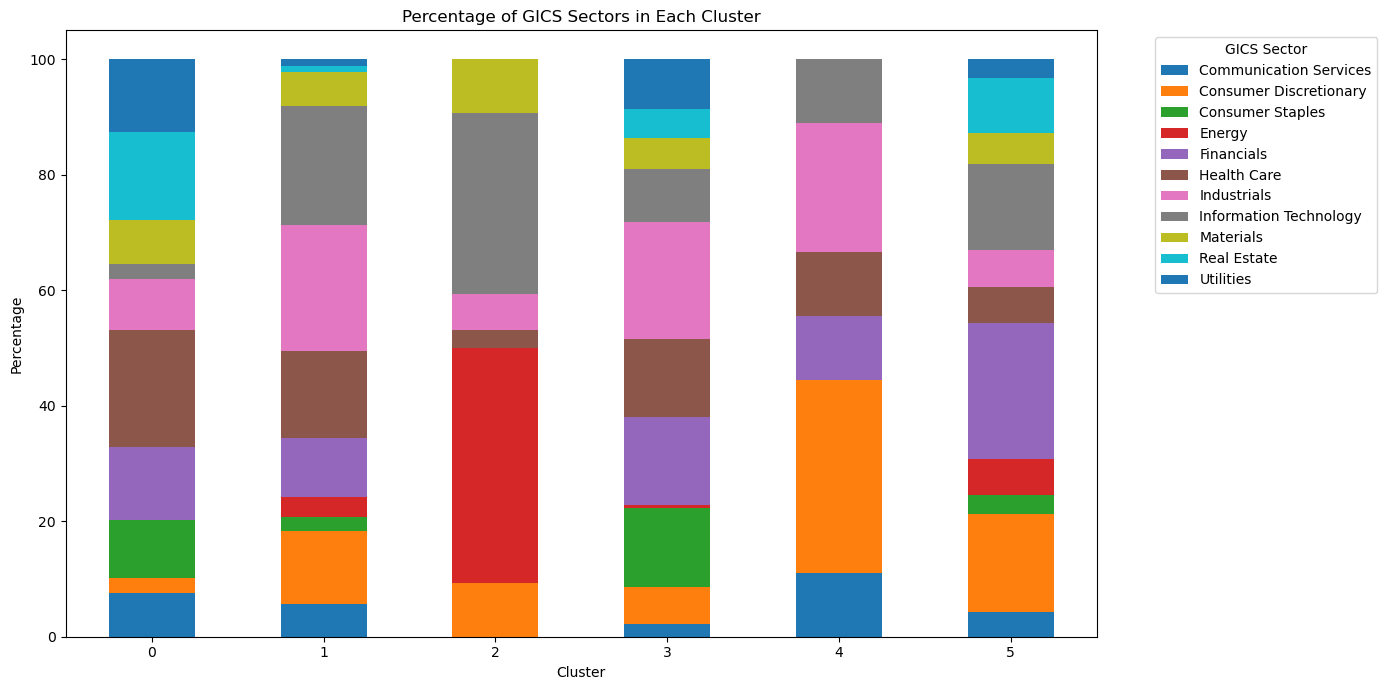

In [32]:
# Calculate the counts of each GICS sector in each cluster
sector_cluster_counts = comparison.groupby(['Cluster', 'GICS Sector']).size().unstack(fill_value=0)

# Calculate the percentages
sector_cluster_percentages = sector_cluster_counts.divide(sector_cluster_counts.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart
ax = sector_cluster_percentages.plot(kind='bar', stacked=True, figsize=(14, 7))

# Set the labels and title
ax.set_xlabel('Cluster')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Percentage')
ax.set_title('Percentage of GICS Sectors in Each Cluster')

# Move the legend out of the plot
plt.legend(title='GICS Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


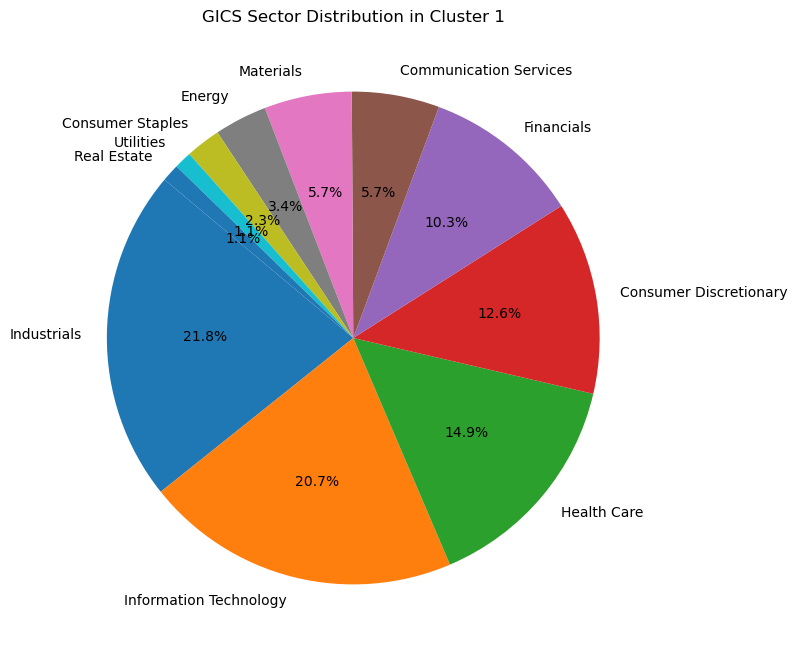

In [35]:
import matplotlib.pyplot as plt

cluster_1_data = comparison[comparison['Cluster'] == 1]

# Count the occurrences of each GICS Sector in cluster 1
sector_counts_cluster_1 = cluster_1_data['GICS Sector'].value_counts()

# Calculate the percentage of each sector
sector_percentage_cluster_1 = (sector_counts_cluster_1 / sector_counts_cluster_1.sum()) * 100

# Plot a pie chart
plt.figure(figsize=(10, 8))
plt.pie(sector_percentage_cluster_1, labels=sector_percentage_cluster_1.index, autopct='%1.1f%%', startangle=140)
plt.title('GICS Sector Distribution in Cluster 1')
plt.show()


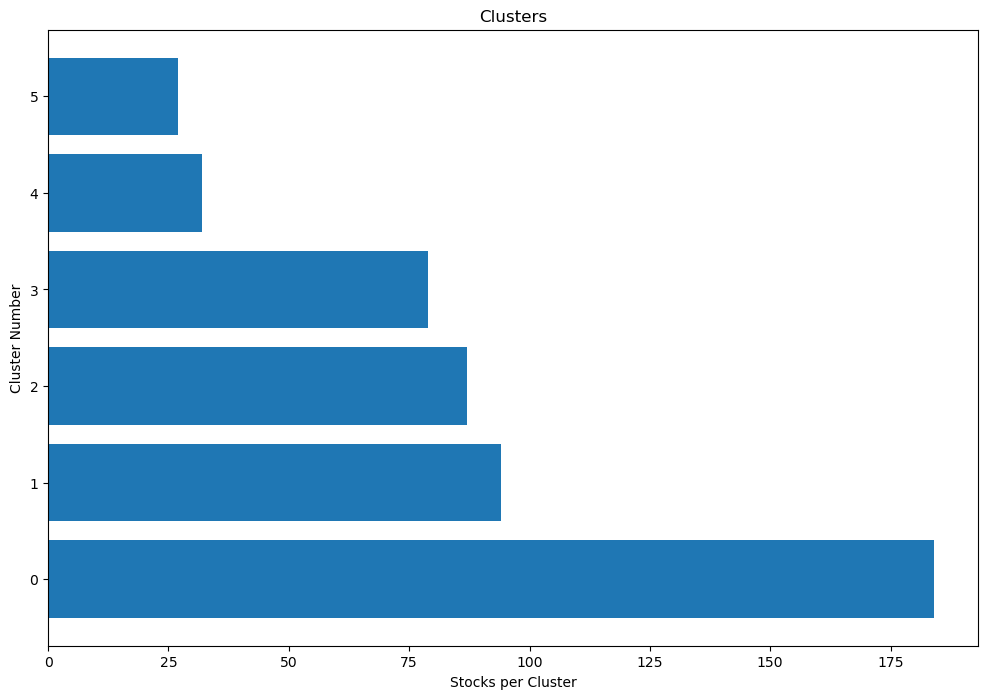

In [41]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [44]:
metrics_df.head()

,Log Return,Volatility
MMM,-0.000299,0.286114
AOS,0.000665,0.316874
ABT,0.000233,0.281844
ABBV,0.000770,0.254391
ACN,0.000546,0.308225


In [45]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 6
Number of Pairs: 57752


In [57]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# Assuming 'cluster_tickers' is a list of tickers in the cluster you're interested in
cluster_tickers = list(comparison[comparison['Cluster']==1].index) # Replace with your actual list of tickers

# Filter the stock_data to include only the companies in your cluster
cluster_stock_data = {ticker: stock_data[ticker] for ticker in cluster_tickers if ticker in stock_data}

# Now proceed with the cointegration test only on the filtered data

def find_cointegrated_pairs(prices):
    n = prices.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = prices.keys()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = prices[keys[i]]
            S2 = prices[keys[j]]
            result = sm.OLS(S1, S2).fit()
            score = result.rsquared
            pvalue = adfuller(result.resid)[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # p-value threshold for cointegration
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# Create a DataFrame from the filtered stock_data dictionary
prices = pd.DataFrame({ticker: data['Adj Close'] for ticker, data in cluster_stock_data.items()})

# Drop any NaNs from the DataFrame
prices.dropna(how='any', inplace=True)

# Find cointegrated pairs within the cluster
scores, pvalues, pairs = find_cointegrated_pairs(prices)
print("Cointegrated pairs in the cluster:", pairs)


Cointegrated pairs in the cluster: [('AOS', 'AFL'), ('AOS', 'ADI'), ('AOS', 'AAPL'), ('AOS', 'AJG'), ('AOS', 'AZO'), ('AOS', 'COR'), ('AOS', 'CMG'), ('AOS', 'CTAS'), ('AOS', 'CEG'), ('AOS', 'COST'), ('AOS', 'FAST'), ('AOS', 'HCA'), ('AOS', 'IDXX'), ('AOS', 'INTU'), ('AOS', 'IRM'), ('AOS', 'LIN'), ('AOS', 'LULU'), ('AOS', 'MLM'), ('AOS', 'MCK'), ('AOS', 'MSFT'), ('AOS', 'MSI'), ('AOS', 'NUE'), ('AOS', 'ORLY'), ('AOS', 'PKG'), ('AOS', 'PGR'), ('AOS', 'PTC'), ('AOS', 'PWR'), ('AOS', 'REGN'), ('AOS', 'NOW'), ('AOS', 'SNA'), ('AOS', 'TMUS'), ('AOS', 'WMB'), ('ABBV', 'BX'), ('ABBV', 'CTRA'), ('ABBV', 'ELV'), ('ABBV', 'LOW'), ('ABBV', 'MS'), ('ABBV', 'MSCI'), ('ABBV', 'POOL'), ('ABBV', 'RJF'), ('ABBV', 'TSCO'), ('ADBE', 'PANW'), ('ADBE', 'NOW'), ('AFL', 'CARR'), ('AFL', 'CTAS'), ('AFL', 'IT'), ('AFL', 'IR'), ('AFL', 'INTU'), ('AFL', 'IRM'), ('AFL', 'LULU'), ('AFL', 'MCK'), ('AFL', 'NUE'), ('AFL', 'ODFL'), ('AFL', 'PTC'), ('AFL', 'TT'), ('GOOGL', 'GOOG'), ('GOOGL', 'BX'), ('GOOGL', 'BG'), ('GO

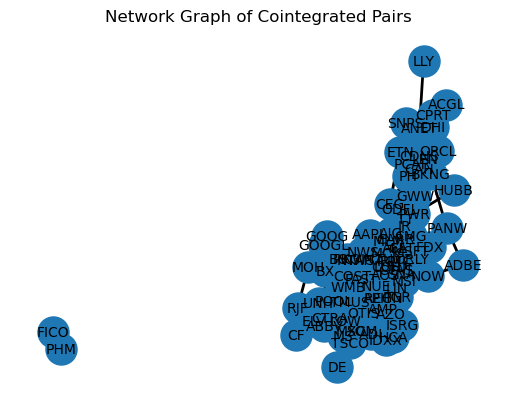

In [94]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'cointegrated_pairs' is a list of tuples representing cointegrated stock pairs
# Example: cointegrated_pairs = [('AAPL', 'MSFT'), ('GOOG', 'AMZN'), ...]

# Create a graph
G = nx.Graph()

# Add edges to the graph (each edge represents a cointegrated pair)
G.add_edges_from(pairs)

# Draw the network
pos = nx.spring_layout(G, seed=671)  # positions for all nodes

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500)

# Draw the edges
nx.draw_networkx_edges(G, pos, width=2)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# Remove the axis
plt.axis('off')

# Show the plot
plt.title('Network Graph of Cointegrated Pairs')
plt.show()


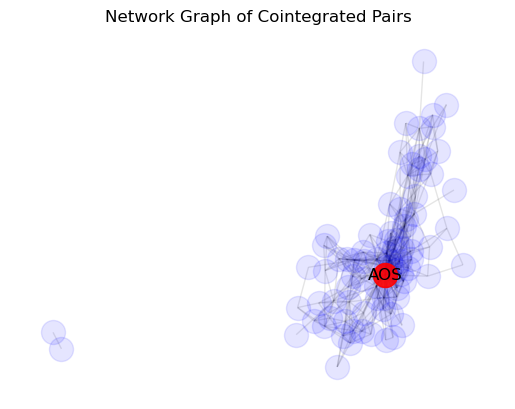

In [73]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your networkx graph

# Calculate degree centrality
centrality = nx.degree_centrality(G)

# Find the node with the highest degree centrality
most_central_node = max(centrality, key=centrality.get)

# Plotting
pos = nx.spring_layout(G, seed=671)  # For consistent layout

# Draw all nodes with low opacity
nx.draw_networkx_nodes(G, pos, node_color='blue', alpha=0.1)

# Draw all edges with low opacity
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Draw the most central node with high opacity and larger size
nx.draw_networkx_nodes(G, pos, nodelist=[most_central_node], node_size=300, node_color='red', alpha=0.9)

# Draw the labels for the most central node
nx.draw_networkx_labels(G, pos, labels={most_central_node: most_central_node}, font_size=12, font_color='black')

# Remove the axis
plt.axis('off')
plt.title('Network Graph of Cointegrated Pairs')

# Show the plot
plt.show()
